<a href="https://www.kaggle.com/code/khizarjamshaid/resnet50v2-accuracy-78?scriptVersionId=169700476" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))


Saving kaggle (1).json to kaggle (1).json
User uploaded file "kaggle (1).json" with length 74 bytes


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json


chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d shehwar/pakistan-currency-pictures-dataset


Dataset URL: https://www.kaggle.com/datasets/shehwar/pakistan-currency-pictures-dataset
License(s): unknown
100% 1.65G/1.65G [01:34<00:00, 20.6MB/s]
100% 1.65G/1.65G [01:34<00:00, 18.7MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('/content/pakistan-currency-pictures-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset-folder')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Import All NecessaryPackages**

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import load_model
import os
import cv2
import numpy as np
from keras.preprocessing import image
from PIL import Image
from tensorflow import lite
#from tensorflow.keras.models import load_model

In [ ]:
!pip show glob
import glob
import os

# **Preprocessing the Data**

In [ ]:
import os
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Re-size all the images to this
IMAGE_SIZE = [224, 224]

# Define paths
train_path = '/content/dataset-folder/Pakistan/Training'
valid_path = '/content/dataset-folder/Pakistan/Valid'


# Useful for getting the number of classes
folders = glob(train_path + '/*')
print(len(folders))

# ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size=(224, 224),
                                                 batch_size=32,
                                                 class_mode='categorical')

test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='categorical')


14
Found 1680 images belonging to 14 classes.
Found 140 images belonging to 14 classes.


In [ ]:
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.optimizers import Adamax
import tensorflow.keras.applications as applications

# Define image dimensions and number of classes
img_h, img_w = 224, 224  # Ensure these match the target_size in ImageDataGenerator
class_count = len(folders)  # Assuming folders contains the paths to the class directories

# Load the ResNet50V2 base model
resnet_base = applications.ResNet50V2(
    include_top=False, weights="imagenet", input_shape=(img_h, img_w, 3), pooling="max"
)

# Make the base model trainable
resnet_base.trainable = True

# Add custom layers on top of the base model
x = resnet_base.output
x = layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = layers.Dense(
    256,
    kernel_regularizer=regularizers.l2(l=0.016),
    activity_regularizer=regularizers.l1(0.006),
    bias_regularizer=regularizers.l1(0.006),
    activation='relu'
)(x)
x = layers.Dropout(rate=0.4, seed=123)(x)
output = layers.Dense(class_count, activation='softmax')(x)

# Create the model
resnet = Model(inputs=resnet_base.input, outputs=output)

# Compile the model
resnet.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary (optional, for verification)
resnet.summary()


94668760/94668760 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                             

# **Run epochs**

In [ ]:
# fit the model
r = resnet.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=40,
  shuffle=True,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-12-ed53736c1f78>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = resnet.fit_generator(


Epoch 1/40
53/53 [==============================] - 152s 2s/step - loss: 10.0082 - accuracy: 0.3244 - val_loss: 16.0061 - val_accuracy: 0.1500
Epoch 2/40
53/53 [==============================] - 89s 2s/step - loss: 7.8589 - accuracy: 0.7262 - val_loss: 10.2736 - val_accuracy: 0.5429
Epoch 3/40
53/53 [==============================] - 91s 2s/step - loss: 6.6503 - accuracy: 0.8935 - val_loss: 7.1549 - val_accuracy: 0.7500
Epoch 4/40
53/53 [==============================] - 86s 2s/step - loss: 5.8141 - accuracy: 0.9363 - val_loss: 5.7706 - val_accuracy: 0.8357
Epoch 5/40
53/53 [==============================] - 85s 2s/step - loss: 5.1065 - accuracy: 0.9649 - val_loss: 5.1618 - val_accuracy: 0.8500
Epoch 6/40
53/53 [==============================] - 91s 2s/step - loss: 4.5166 - accuracy: 0.9744 - val_loss: 4.4341 - val_accuracy: 0.8929
Epoch 7/40
53/53 [==============================] - 88s 2s/step - loss: 3.9881 - accuracy: 0.9798 - val_loss: 3.8795 - val_accuracy: 0.9500
Epoch 8/40
53/53

# **Loss Graph**

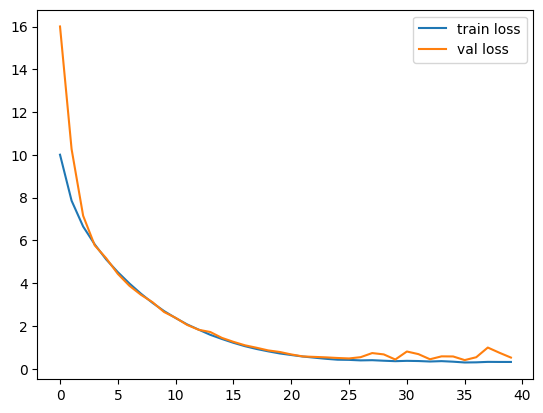

In [ ]:
## loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

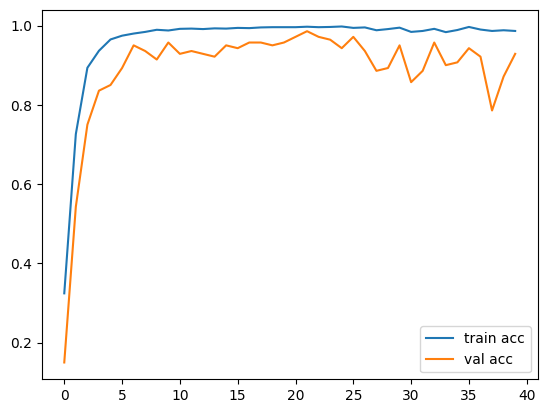

In [ ]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')  # Corrected key
plt.legend()
plt.show()
#plt.savefig('AccVal_acc')

# **Saved Model**

In [ ]:
model_save_path = '/content/dataset-folder/ResNet50V2.keras'
resnet.save(model_save_path)
resnet.save('/content/drive/My Drive/ResNet50V2.h5')
resnet.save('/content/drive/My Drive/ResNet50V2.keras')


print('Your Model is==> ',os.getcwd())
# Confirm the save path
print(f"Model saved successfully at: {model_save_path}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Your Model is==>  /content
Model saved successfully at: /content/dataset-folder/ResNet50V2.keras


# **Testing The Model**

In [ ]:
# Load the trained model
model_path = "/content/drive/MyDrive/ResNet50V2.h5"
# Update with the actual path to your saved model
loaded_model = load_model(model_path)



1/1 [==============================] - 4s 4s/step


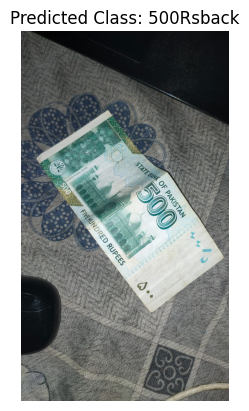

In [ ]:

# Get the class names
# class_names = sorted(training_set.class_indices.keys())
# print(class_names)
class_names = [
    '1000Rs', '1000Rsback', '100Rs', '100Rsback', '10Rs', '10Rsback',
    '20Rs', '20Rsback', '5000Rs', '5000Rsback', '500Rs', '500Rsback',
    '50Rs', '50Rsback'
]


# Specify the path to the test image
test_img_path = '/content/WhatsApp Image 2024-06-06 at 00.42.25_a1adf9b4.jpg'

# Function to preprocess an image
def preprocess_img(img_path):
    img = Image.open(img_path)  # Use PIL to open the image
    img = img.resize((224, 224))  # Resize the image
    img_array = np.array(img)  # Convert PIL image to NumPy array
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Function to predict the class of an image
def predict_class(img_path):
    img = preprocess_img(img_path)
    prediction = loaded_model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]
    return predicted_class

# Predict the class for the test image
predicted_class = predict_class(test_img_path)

# Display the test image and predicted class
test_img = cv2.imread(test_img_path)
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()
